# Notebook: Testing Library's RJVMC for Binary Classification

This notebook demonstrates how to use the RJVMC (Reversible Jump Variational Monte Carlo) functionality from the `infodynamics_jax` library for binary classification with non-conjugate likelihoods.

**Learning Objectives:**
- Use the library's RJVMC for binary classification with Bernoulli likelihood
- Understand the difference between RJ-MCMC (conjugate) and RJVMC (non-conjugate)
- Visualize MCMC traces and results

## 1. Setup and Imports

In [ ]:
# Setup path and imports
import sys
from pathlib import Path
cwd = Path.cwd().resolve()
candidates = [cwd, *cwd.parents]
for p in candidates:
    if (p / 'infodynamics_jax').is_dir():
        sys.path.insert(0, str(p))
        break

import os
os.environ['JAX_PLATFORMS'] = 'cpu'

import jax
import jax.numpy as jnp
import jax.random as jrand
import numpy as np
import matplotlib.pyplot as plt
import time

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

# Import RJVMC from library
from infodynamics_jax.inference.rj.rjvmc import RJVMC, RJVMCCFG
from infodynamics_jax.energy import InertialEnergy, InertialCFG
from infodynamics_jax.gp.kernels import rbf as rbf_kernel
from infodynamics_jax.gp.likelihoods import bernoulli

print(f"JAX version: {jax.__version__}")
print(f"JAX platform: {jax.default_backend()}")
print("✓ Successfully imported RJVMC and related functions from library")

JAX version: 0.8.2
JAX platform: cpu


## 2. Generate Binary Classification Data

In [ ]:
# Generate binary classification data
def generate_binary_data(N=200, seed=42):
    """Generate step function binary classification data"""
    np.random.seed(seed)
    X = np.sort(np.random.uniform(0, 2.0, (N, 1)), axis=0)
    # Create a step function: y=1 if x > 1.0, else y=0
    y_true = (X.flatten() > 1.0).astype(float)
    # Add some noise (flip some labels)
    flip_idx = np.random.choice(N, size=int(0.1 * N), replace=False)
    y01 = y_true.copy()
    y01[flip_idx] = 1 - y01[flip_idx]
    return X, y01, y_true

# Generate data
X, y01, y_true = generate_binary_data(N=200, seed=42)
X_j = jnp.array(X, dtype=jnp.float64)
y01_j = jnp.array(y01, dtype=jnp.float64)

print(f"Data size: X={X_j.shape}, y={y01_j.shape}")
print(f"X range: [{X_j.min():.2f}, {X_j.max():.2f}]")
print(f"y classes: {np.unique(y01)}")
print(f"Class distribution: {np.bincount(y01.astype(int))}")

### 1) Bernoulli-logit Likelihood + GH Expectations

In [26]:
@jax.jit
def loglik_bernoulli_logit(y01, f):
    # y in {0,1}
    # log p(y|f) = y*log(sigmoid(f)) + (1-y)*log(1-sigmoid(f))
    return -softplus(-f) * y01 - softplus(f) * (1.0 - y01)

@jax.jit
def gh_expect_loglik_bernoulli(mu, var, y01, gh_x, gh_w):
    sig = jnp.sqrt(jnp.maximum(var, 1e-18))
    f = mu[:, None] + jnp.sqrt(2.0) * sig[:, None] * gh_x[None, :]
    ll = loglik_bernoulli_logit(y01[:, None], f)
    return (ll * gh_w[None, :]).sum(axis=1) / jnp.sqrt(jnp.pi)

@jax.jit
def gh_expect_sigmoid(mu, var, gh_x, gh_w):
    sig = jnp.sqrt(jnp.maximum(var, 1e-18))
    f = mu[:, None] + jnp.sqrt(2.0) * sig[:, None] * gh_x[None, :]
    p = sigmoid(f)
    return (p * gh_w[None, :]).sum(axis=1) / jnp.sqrt(jnp.pi)

### 2) State (PyTree) with Caches

In [27]:
@jax.tree_util.register_pytree_node_class
@dataclass
class State:
    theta: jnp.ndarray     # (D+1,) [log_ls(D), log_sf]
    Z_buf: jnp.ndarray     # (M_max,) int32
    M: jnp.ndarray         # () int32

    m: jnp.ndarray         # (M_max,)
    L: jnp.ndarray         # (M_max,M_max) lower-tri

    # cached GP factors (for current theta/Z/M)
    Kuu: jnp.ndarray       # (M_max,M_max)
    Lm: jnp.ndarray        # chol(Kuu) lower
    Kuf: jnp.ndarray       # (M_max,N)
    A: jnp.ndarray         # solve(Lm, Kuf)
    A2: jnp.ndarray        # solve(Lm.T, A) == Kuu^{-1} Kuf

    elbo: jnp.ndarray      # ()

    def tree_flatten(self):
        children = (
            self.theta, self.Z_buf, self.M,
            self.m, self.L,
            self.Kuu, self.Lm, self.Kuf, self.A, self.A2,
            self.elbo
        )
        return children, None

    @classmethod
    def tree_unflatten(cls, aux, children):
        return cls(*children)

### 3) Priors

In [28]:
@jax.jit
def log_prior_theta(theta, ls_mean=-2.0, ls_scale=1.2, sf_scale=1.5):
    lp_ls = -0.5 * jnp.sum(((theta[:-1] - ls_mean) / ls_scale) ** 2)
    lp_sf = -0.5 * (theta[-1] / sf_scale) ** 2
    return lp_ls + lp_sf

@jax.jit
def log_prior_M_trunc_geom(M, M_min, M_max, p_geom):
    m = M - M_min
    valid = (M >= M_min) & (M <= M_max)
    K = M_max - M_min + 1
    log_unn = jnp.log(p_geom) + m * jnp.log1p(-p_geom)
    logZ = jnp.log1p(-(1.0 - p_geom) ** K)
    return jnp.where(valid, log_unn - logZ, -jnp.inf)

@jax.jit
def log_prior_ordered_Z_given_M(N, M):
    Nf = jnp.array(N, dtype=jnp.float64)
    Mf = jnp.array(M, dtype=jnp.float64)
    return -(jsp.special.gammaln(Nf + 1.0) - jsp.special.gammaln(Nf - Mf + 1.0))

@jax.jit
def log_posterior(state: State, N, M_min, M_max, p_geom):
    return (state.elbo
            + log_prior_theta(state.theta)
            + log_prior_M_trunc_geom(state.M, M_min, M_max, p_geom)
            + log_prior_ordered_Z_given_M(N, state.M))

### 4) Build Full Caches

In [29]:
@jax.jit
def build_gp_factors_full(theta, Z_buf, M, X, jitter):
    N, D = X.shape
    M_max = Z_buf.shape[0]

    log_ls = theta[:D]
    log_sf = theta[D]

    mask = (jnp.arange(M_max, dtype=jnp.int32) < M.astype(jnp.int32)).astype(X.dtype)
    active = mask[:, None] * mask[None, :]

    Z = X[Z_buf]
    Kuu_raw = rbf_kernel(Z, Z, log_ls, log_sf)
    Kuf_raw = rbf_kernel(Z, X, log_ls, log_sf)

    # safe inactive block: identity + jitter
    Kuu = active * Kuu_raw + jnp.diag(1.0 - mask) + jitter * jnp.eye(M_max)
    Kuf = mask[:, None] * Kuf_raw

    Lm = jsp.linalg.cholesky(Kuu, lower=True)
    A = jsp.linalg.solve_triangular(Lm, Kuf, lower=True)
    A2 = jsp.linalg.solve_triangular(Lm.T, A, lower=False)
    return Kuu, Lm, Kuf, A, A2

### 5) ELBO Calculations (Full & Subset)

In [30]:
@jax.jit
def elbo_cached_binary_full(state: State, X, y01, gh_x, gh_w):
    N, D = X.shape
    M_max = state.Z_buf.shape[0]
    mask = (jnp.arange(M_max, dtype=jnp.int32) < state.M.astype(jnp.int32)).astype(jnp.float64)
    active = mask[:, None] * mask[None, :]

    m = state.m * mask
    Lq = jnp.tril(state.L) * active
    S = Lq @ Lq.T

    # alpha = Kuu^{-1} m
    tmp = jsp.linalg.solve_triangular(state.Lm, m[:, None], lower=True)
    alpha = jsp.linalg.solve_triangular(state.Lm.T, tmp, lower=False).reshape(-1)

    mu = (state.Kuf.T @ alpha).reshape(-1)

    log_sf = state.theta[-1]
    sf2 = jnp.exp(2.0 * log_sf)
    kff = sf2 * jnp.ones((N,), dtype=jnp.float64)

    Q = (S - state.Kuu) * active
    quad = jnp.einsum("mi,mn,ni->i", state.A2, Q, state.A2)
    var = jnp.maximum(kff + quad, 1e-12)

    ell = gh_expect_loglik_bernoulli(mu, var, y01.reshape(-1), gh_x, gh_w).sum()

    # KL(q(u)||p(u))
    S_jit = S + 1e-8 * jnp.eye(M_max)
    logdetK = 2.0 * jnp.sum(jnp.log(jnp.diag(state.Lm)))
    Ls = jsp.linalg.cholesky(S_jit, lower=True)
    logdetS = 2.0 * jnp.sum(jnp.log(jnp.diag(Ls)))

    Sinv1 = jsp.linalg.solve_triangular(state.Lm, S, lower=True)
    KinvS = jsp.linalg.solve_triangular(state.Lm.T, Sinv1, lower=False)
    trKinvS = jnp.trace(KinvS)

    mKm = jnp.dot(alpha, m)
    M_eff = state.M.astype(jnp.float64)
    KL = 0.5 * (trKinvS + mKm - M_eff + logdetK - logdetS)

    return ell - KL

@jax.jit
def elbo_cached_binary_subset(state: State, X, y01, idx, gh_x, gh_w):
    # Subset ELBO used only for DA stage-1 screening (approximate)
    # We scale likelihood term by N/|B|, keep KL unchanged (coarse but stable).
    N, D = X.shape
    B = idx.shape[0]

    M_max = state.Z_buf.shape[0]
    mask = (jnp.arange(M_max, dtype=jnp.int32) < state.M.astype(jnp.int32)).astype(jnp.float64)
    active = mask[:, None] * mask[None, :]

    m = state.m * mask
    Lq = jnp.tril(state.L) * active
    S = Lq @ Lq.T

    tmp = jsp.linalg.solve_triangular(state.Lm, m[:, None], lower=True)
    alpha = jsp.linalg.solve_triangular(state.Lm.T, tmp, lower=False).reshape(-1)

    Kuf_b = jnp.take(state.Kuf, idx, axis=1)   # (M_max,B)
    A2_b  = jnp.take(state.A2,  idx, axis=1)   # (M_max,B)
    y_b   = jnp.take(y01.reshape(-1), idx, axis=0)

    mu = (Kuf_b.T @ alpha).reshape(-1)

    log_sf = state.theta[-1]
    sf2 = jnp.exp(2.0 * log_sf)
    kff = sf2 * jnp.ones((B,), dtype=jnp.float64)

    Q = (S - state.Kuu) * active
    quad = jnp.einsum("mi,mn,ni->i", A2_b, Q, A2_b)
    var = jnp.maximum(kff + quad, 1e-12)

    ell_b = gh_expect_loglik_bernoulli(mu, var, y_b, gh_x, gh_w).sum()
    ell = (jnp.array(N, jnp.float64) / jnp.array(B, jnp.float64)) * ell_b

    # KL same as full (cheap-ish, but dimension M dominates anyway)
    S_jit = S + 1e-8 * jnp.eye(M_max)
    logdetK = 2.0 * jnp.sum(jnp.log(jnp.diag(state.Lm)))
    Ls = jsp.linalg.cholesky(S_jit, lower=True)
    logdetS = 2.0 * jnp.sum(jnp.log(jnp.diag(Ls)))

    Sinv1 = jsp.linalg.solve_triangular(state.Lm, S, lower=True)
    KinvS = jsp.linalg.solve_triangular(state.Lm.T, Sinv1, lower=False)
    trKinvS = jnp.trace(KinvS)

    mKm = jnp.dot(alpha, m)
    M_eff = state.M.astype(jnp.float64)
    KL = 0.5 * (trKinvS + mKm - M_eff + logdetK - logdetS)

    return ell - KL

### 6) Adam Inner VI for (m,L)

In [31]:
@jax.jit
def adam_init(param):
    return jnp.zeros_like(param), jnp.zeros_like(param)

@jax.jit
def adam_update(param, grad, m1, m2, t, lr, b1=0.9, b2=0.999, eps=1e-8):
    m1 = b1 * m1 + (1 - b1) * grad
    m2 = b2 * m2 + (1 - b2) * (grad * grad)
    m1h = m1 / (1 - b1 ** t)
    m2h = m2 / (1 - b2 ** t)
    param = param + lr * m1h / (jnp.sqrt(m2h) + eps)
    return param, m1, m2

@partial(jax.jit, static_argnames=("inner_steps",))
def optimise_variational(state: State, X, y01, gh_x, gh_w, inner_steps: int, lr_m: float, lr_L: float):
    m, L = state.m, state.L
    m_m1, m_m2 = adam_init(m)
    L_m1, L_m2 = adam_init(L)

    def obj(mm, LL):
        st = State(
            state.theta, state.Z_buf, state.M,
            mm, LL,
            state.Kuu, state.Lm, state.Kuf, state.A, state.A2,
            state.elbo
        )
        return elbo_cached_binary_full(st, X, y01, gh_x, gh_w)

    def body(carry, t):
        m, L, m_m1, m_m2, L_m1, L_m2 = carry
        val, (gm, gL) = jax.value_and_grad(obj, argnums=(0, 1))(m, L)
        gL = jnp.tril(gL)
        m, m_m1, m_m2 = adam_update(m, gm, m_m1, m_m2, t+1, lr=lr_m)
        L, L_m1, L_m2 = adam_update(L, gL, L_m1, L_m2, t+1, lr=lr_L)
        return (m, L, m_m1, m_m2, L_m1, L_m2), val

    (m, L, *_), _ = jax.lax.scan(
        body, (m, L, m_m1, m_m2, L_m1, L_m2),
        jnp.arange(inner_steps, dtype=jnp.int32)
    )

    # stabilise diag
    diag = jnp.maximum(jnp.diag(L), 1e-6)
    L = L.at[jnp.diag_indices(L.shape[0])].set(diag)

    st2 = State(
        state.theta, state.Z_buf, state.M,
        m, L,
        state.Kuu, state.Lm, state.Kuf, state.A, state.A2,
        state.elbo
    )
    elbo = elbo_cached_binary_full(st2, X, y01, gh_x, gh_w)

    return State(
        state.theta, state.Z_buf, state.M,
        m, L,
        state.Kuu, state.Lm, state.Kuf, state.A, state.A2,
        elbo
    )

### 7) Rank-1 Cached Structural Updates

In [32]:
@jax.jit
def birth_append_rank1_noelbo(state: State, new_idx, X, jitter):
    N, D = X.shape
    M_max = state.Z_buf.shape[0]
    M = state.M.astype(jnp.int32)
    slot = M

    Z_buf_new = state.Z_buf.at[slot].set(new_idx.astype(jnp.int32))
    M_new = (M + 1).astype(jnp.int32)

    Z_old = X[state.Z_buf]
    z_new = X[new_idx].reshape(1, -1)

    log_ls = state.theta[:-1]
    log_sf = state.theta[-1]

    k_row = rbf_kernel(z_new, Z_old, log_ls, log_sf).reshape(-1)
    k_self = rbf_kernel(z_new, z_new, log_ls, log_sf).reshape(()) + jitter

    mask_old = (jnp.arange(M_max, dtype=jnp.int32) < M).astype(jnp.float64)
    k_row = k_row * mask_old

    v = jsp.linalg.solve_triangular(state.Lm, k_row[:, None], lower=True).reshape(-1)
    v = v * mask_old
    diag = jnp.sqrt(jnp.maximum(k_self - jnp.dot(v, v), 1e-12))

    # Lm update
    Lm_new = state.Lm
    Lm_new = Lm_new.at[slot, :].set(0.0)
    Lm_new = Lm_new.at[:, slot].set(0.0)
    Lm_new = Lm_new.at[slot, :].set(v)
    Lm_new = Lm_new.at[slot, slot].set(diag)

    # Kuu update
    Kuu_new = state.Kuu
    Kuu_new = Kuu_new.at[slot, :].set(0.0)
    Kuu_new = Kuu_new.at[:, slot].set(0.0)
    Kuu_new = Kuu_new.at[slot, :].set(k_row)
    Kuu_new = Kuu_new.at[:, slot].set(k_row)
    Kuu_new = Kuu_new.at[slot, slot].set(k_self)

    # Kuf row
    Kuf_new = state.Kuf
    kuf_row = rbf_kernel(z_new, X, log_ls, log_sf).reshape(-1)
    Kuf_new = Kuf_new.at[slot, :].set(kuf_row)

    # A update
    A_new = state.A
    numer = kuf_row - (v[:, None] * state.A).sum(axis=0)
    a_row = numer / (diag + 1e-30)
    A_new = A_new.at[slot, :].set(a_row)

    # A2 update (block)
    A2_new = state.A2
    x_new = a_row / (diag + 1e-30)
    delta = jsp.linalg.solve_triangular(state.Lm.T, v[:, None], lower=False).reshape(-1)
    delta = delta * mask_old
    A2_new = A2_new - delta[:, None] * x_new[None, :]
    A2_new = A2_new.at[slot, :].set(x_new)

    # variational params for new slot
    m_new = state.m.at[slot].set(0.0)
    Lq_new = state.L
    Lq_new = Lq_new.at[slot, :].set(0.0)
    Lq_new = Lq_new.at[:, slot].set(0.0)
    Lq_new = Lq_new.at[slot, slot].set(1.0)

    return State(
        state.theta, Z_buf_new, M_new,
        m_new, Lq_new,
        Kuu_new, Lm_new, Kuf_new, A_new, A2_new,
        state.elbo
    )

@jax.jit
def death_drop_last_rank1_noelbo(state: State):
    M_max = state.Z_buf.shape[0]
    M = state.M.astype(jnp.int32)
    slot = (M - 1).astype(jnp.int32)
    M_new = (M - 1).astype(jnp.int32)

    mask_old = (jnp.arange(M_max, dtype=jnp.int32) < slot).astype(jnp.float64)

    v = state.Lm[slot, :] * mask_old
    diag = state.Lm[slot, slot]

    # reverse A2
    x_new = state.A2[slot, :]
    delta = jsp.linalg.solve_triangular(state.Lm.T, v[:, None], lower=False).reshape(-1)
    delta = delta * mask_old

    A2_new = state.A2
    A2_new = A2_new + delta[:, None] * x_new[None, :]
    A2_new = A2_new.at[slot, :].set(0.0)

    A_new = state.A.at[slot, :].set(0.0)
    Kuf_new = state.Kuf.at[slot, :].set(0.0)

    Kuu_new = state.Kuu
    Kuu_new = Kuu_new.at[slot, :].set(0.0)
    Kuu_new = Kuu_new.at[:, slot].set(0.0)
    Kuu_new = Kuu_new.at[slot, slot].set(1.0)

    Lm_new = state.Lm
    Lm_new = Lm_new.at[slot, :].set(0.0)
    Lm_new = Lm_new.at[:, slot].set(0.0)
    Lm_new = Lm_new.at[slot, slot].set(1.0)

    m_new = state.m.at[slot].set(0.0)
    Lq_new = state.L
    Lq_new = Lq_new.at[slot, :].set(0.0)
    Lq_new = Lq_new.at[:, slot].set(0.0)
    Lq_new = Lq_new.at[slot, slot].set(1.0)

    return State(
        state.theta, state.Z_buf, M_new,
        m_new, Lq_new,
        Kuu_new, Lm_new, Kuf_new, A_new, A2_new,
        state.elbo
    )

### 8) Pool-choose for Birth

In [33]:
@partial(jax.jit, static_argnames=("K_pool",))
def birth_pool_choose(key, state: State, X, y01, gh_x, gh_w,
                      M_min, M_max, K_pool: int,
                      temp, p_geom, jitter, batch_idx):
    N = X.shape[0]
    M = state.M.astype(jnp.int32)
    M_max_buf = state.Z_buf.shape[0]
    slot_ok = M < M_max_buf

    cand = jrand.randint(key, (K_pool,), 0, N, dtype=jnp.int32)
    active_mask = (jnp.arange(M_max_buf, dtype=jnp.int32) < M)

    def is_dup(i):
        return jnp.any(jnp.where(active_mask, state.Z_buf == i, False))

    lpM_curr = log_prior_M_trunc_geom(M, M_min, M_max, p_geom)
    lpM_prop = log_prior_M_trunc_geom(M + 1, M_min, M_max, p_geom)
    d_lpM = lpM_prop - lpM_curr
    d_lpz = log_prior_ordered_Z_given_M(N, M + 1) - log_prior_ordered_Z_given_M(N, M)

    # current approx elbo on batch (cached)
    elbo_hat_curr = elbo_cached_binary_subset(state, X, y01, batch_idx, gh_x, gh_w)

    def score_one(i):
        valid = slot_ok & (~is_dup(i))
        prop_struct = birth_append_rank1_noelbo(state, i, X, jitter)
        elbo_hat_prop = elbo_cached_binary_subset(prop_struct, X, y01, batch_idx, gh_x, gh_w)
        d_elbo_hat = elbo_hat_prop - elbo_hat_curr
        return jnp.where(valid, d_elbo_hat + d_lpM + d_lpz, -jnp.inf)

    deltas = jax.vmap(score_one)(cand)
    probs = softmax_stable(deltas, temp=temp)

    key2 = jrand.split(key, 2)[1]
    j = jrand.choice(key2, a=K_pool, p=probs)
    return cand[j], probs[j]

### 9) RJ with Delayed Acceptance (DA)

In [34]:
@partial(jax.jit, static_argnames=("K_pool",))
def rj_step_DA(key, state: State, X, y01, gh_x, gh_w,
               M_min, M_max, K_pool: int,
               temp_birth, p_geom, jitter, batch_idx):
    N = X.shape[0]
    key, k_move, k_pool, k_acc1, k_acc2 = jrand.split(key, 5)

    M = state.M.astype(jnp.int32)
    p_birth = jnp.where(M <= M_min, 1.0, jnp.where(M >= M_max, 0.0, 0.5))
    do_birth = jrand.uniform(k_move) < p_birth

    lp_curr = log_posterior(state, N, M_min, M_max, p_geom)
    elbo_hat_curr = elbo_cached_binary_subset(state, X, y01, batch_idx, gh_x, gh_w)
    lp_hat_curr = (elbo_hat_curr
                   + log_prior_theta(state.theta)
                   + log_prior_M_trunc_geom(state.M, M_min, M_max, p_geom)
                   + log_prior_ordered_Z_given_M(N, state.M))

    def birth_branch():
        idx_new, q_choose = birth_pool_choose(
            k_pool, state, X, y01, gh_x, gh_w,
            M_min, M_max, K_pool, temp_birth, p_geom, jitter, batch_idx
        )
        prop_struct = birth_append_rank1_noelbo(state, idx_new, X, jitter)
        elbo_hat_prop = elbo_cached_binary_subset(prop_struct, X, y01, batch_idx, gh_x, gh_w)
        lp_hat_prop = (elbo_hat_prop
                       + log_prior_theta(prop_struct.theta)
                       + log_prior_M_trunc_geom(prop_struct.M, M_min, M_max, p_geom)
                       + log_prior_ordered_Z_given_M(N, prop_struct.M))

        M_prop = prop_struct.M.astype(jnp.int32)
        p_birth_rev = jnp.where(M_prop <= M_min, 1.0, jnp.where(M_prop >= M_max, 0.0, 0.5))
        p_death_rev = 1.0 - p_birth_rev

        q_fwd = p_birth * q_choose
        q_bwd = p_death_rev * 1.0

        loga_hat = (lp_hat_prop - lp_hat_curr) + jnp.log(q_bwd + 1e-30) - jnp.log(q_fwd + 1e-30)
        pass1 = jnp.log(jrand.uniform(k_acc1)) < jnp.minimum(0.0, loga_hat)

        def stage2():
            elbo_prop = elbo_cached_binary_full(prop_struct, X, y01, gh_x, gh_w)
            prop = State(
                prop_struct.theta, prop_struct.Z_buf, prop_struct.M,
                prop_struct.m, prop_struct.L,
                prop_struct.Kuu, prop_struct.Lm, prop_struct.Kuf, prop_struct.A, prop_struct.A2,
                elbo_prop
            )
            lp_prop = log_posterior(prop, N, M_min, M_max, p_geom)
            loga = (lp_prop - lp_curr) + jnp.log(q_bwd + 1e-30) - jnp.log(q_fwd + 1e-30)
            acc2 = jnp.log(jrand.uniform(k_acc2)) < jnp.minimum(0.0, loga)
            return jax.lax.cond(acc2, lambda: prop, lambda: state)

        return jax.lax.cond(pass1, stage2, lambda: state)

    def death_branch():
        can = M > M_min
        def do_death_inner():
            prop_struct = death_drop_last_rank1_noelbo(state)
            elbo_hat_prop = elbo_cached_binary_subset(prop_struct, X, y01, batch_idx, gh_x, gh_w)
            lp_hat_prop = (elbo_hat_prop
                           + log_prior_theta(prop_struct.theta)
                           + log_prior_M_trunc_geom(prop_struct.M, M_min, M_max, p_geom)
                           + log_prior_ordered_Z_given_M(N, prop_struct.M))

            p_death = 1.0 - p_birth
            M_prop = prop_struct.M.astype(jnp.int32)
            p_birth_rev = jnp.where(M_prop <= M_min, 1.0, jnp.where(M_prop >= M_max, 0.0, 0.5))
            q_fwd = p_death * 1.0
            q_bwd = p_birth_rev * (1.0 / jnp.maximum(1.0, (N - M_prop).astype(jnp.float64)))

            loga_hat = (lp_hat_prop - lp_hat_curr) + jnp.log(q_bwd + 1e-30) - jnp.log(q_fwd + 1e-30)
            pass1 = jnp.log(jrand.uniform(k_acc1)) < jnp.minimum(0.0, loga_hat)

            def stage2():
                elbo_prop = elbo_cached_binary_full(prop_struct, X, y01, gh_x, gh_w)
                prop = State(
                    prop_struct.theta, prop_struct.Z_buf, prop_struct.M,
                    prop_struct.m, prop_struct.L,
                    prop_struct.Kuu, prop_struct.Lm, prop_struct.Kuf, prop_struct.A, prop_struct.A2,
                    elbo_prop
                )
                lp_prop = log_posterior(prop, N, M_min, M_max, p_geom)
                loga = (lp_prop - lp_curr) + jnp.log(q_bwd + 1e-30) - jnp.log(q_fwd + 1e-30)
                acc2 = jnp.log(jrand.uniform(k_acc2)) < jnp.minimum(0.0, loga)
                return jax.lax.cond(acc2, lambda: prop, lambda: state)
            return jax.lax.cond(pass1, stage2, lambda: state)
        return jax.lax.cond(can, do_death_inner, lambda: state)

    return jax.lax.cond(do_birth, birth_branch, death_branch)

### 10) Theta update (HMC)

In [35]:
@partial(jax.jit, static_argnames=("hmc_steps",))
def hmc_update_theta(key, state: State, X, y01, gh_x, gh_w,
                     M_min, M_max, p_geom,
                     hmc_step_size, hmc_steps: int,
                     jitter):
    N, D = X.shape
    def logprob(theta):
        Kuu, Lm, Kuf, A, A2 = build_gp_factors_full(theta, state.Z_buf, state.M, X, jitter)
        st = State(theta, state.Z_buf, state.M, state.m, state.L, Kuu, Lm, Kuf, A, A2, state.elbo)
        elbo = elbo_cached_binary_full(st, X, y01, gh_x, gh_w)
        st = State(theta, state.Z_buf, state.M, state.m, state.L, Kuu, Lm, Kuf, A, A2, elbo)
        return log_posterior(st, N, M_min, M_max, p_geom)

    hmc = blackjax.hmc(logprob, step_size=hmc_step_size, inverse_mass_matrix=jnp.ones_like(state.theta), num_integration_steps=hmc_steps)
    s0 = hmc.init(state.theta)
    s1, _ = hmc.step(key, s0)
    theta_new = s1.position

    Kuu, Lm, Kuf, A, A2 = build_gp_factors_full(theta_new, state.Z_buf, state.M, X, jitter)
    st = State(theta_new, state.Z_buf, state.M, state.m, state.L, Kuu, Lm, Kuf, A, A2, state.elbo)
    elbo = elbo_cached_binary_full(st, X, y01, gh_x, gh_w)
    return State(theta_new, state.Z_buf, state.M, state.m, state.L, Kuu, Lm, Kuf, A, A2, elbo)

### 11) Chain (Config + run_chain)

In [36]:
@dataclass(frozen=True)
class Config:
    seed: int = 0
    n_steps: int = 260
    burn: int = 70
    M_min: int = 6
    M_max: int = 60
    M_init: int = 18
    K_pool: int = 64
    temp_birth: float = 1.0
    p_geom: float = 0.12
    B_da: int = 256
    inner_steps: int = 6
    lr_m: float = 0.03
    lr_L: float = 0.012
    theta_every: int = 2
    hmc_step_size: float = 0.02
    hmc_steps: int = 3
    gh_K: int = 20
    jitter: float = 1e-6
    thin: int = 5
    max_draws: int = 200
    thin_grid: int = 8
    max_draws_grid: int = 120

@partial(jax.jit, static_argnames=("n_steps","M_min","M_max","M_init","K_pool","theta_every","hmc_steps","inner_steps","B_da"))
def run_chain(key, X, y01, gh_x, gh_w, n_steps, M_min, M_max, M_init, K_pool, temp_birth, p_geom, B_da, inner_steps, lr_m, lr_L, theta_every, hmc_step_size, hmc_steps, jitter):
    N, D = X.shape
    M_max_buf = M_max
    Z_buf = jnp.mod(jnp.arange(M_max_buf, dtype=jnp.int32), jnp.array(N, dtype=jnp.int32))
    M0 = jnp.array(M_init, dtype=jnp.int32)
    theta0 = jnp.concatenate([jnp.full((D,), -1.0, dtype=jnp.float64), jnp.array([0.0], dtype=jnp.float64)], axis=0)
    m0, L0 = jnp.zeros((M_max_buf,)), jnp.eye(M_max_buf)
    Kuu0, Lm0, Kuf0, A0, A20 = build_gp_factors_full(theta0, Z_buf, M0, X, jitter)
    dummy = State(theta0, Z_buf, M0, m0, L0, Kuu0, Lm0, Kuf0, A0, A20, jnp.array(0.0))
    elbo0 = elbo_cached_binary_full(dummy, X, y01, gh_x, gh_w)
    state0 = State(theta0, Z_buf, M0, m0, L0, Kuu0, Lm0, Kuf0, A0, A20, elbo0)

    def one_step(carry, t):
        key, st = carry
        key, k_th, k_rj, k_b = jrand.split(key, 4)
        st = optimise_variational(st, X, y01, gh_x, gh_w, inner_steps=inner_steps, lr_m=lr_m, lr_L=lr_L)
        do_theta = (t % theta_every) == 0
        st = jax.lax.cond(do_theta, lambda: hmc_update_theta(k_th, st, X, y01, gh_x, gh_w, M_min, M_max, p_geom, hmc_step_size, hmc_steps, jitter), lambda: st)
        batch_idx = jrand.randint(k_b, (B_da,), 0, N, dtype=jnp.int32)
        st = rj_step_DA(k_rj, st, X, y01, gh_x, gh_w, M_min, M_max, K_pool, temp_birth, p_geom, jitter, batch_idx)
        return (key, st), (st.elbo, st.M, st.theta, st.m, st.L, st.Z_buf)

    (_, _), hist = jax.lax.scan(one_step, (key, state0), jnp.arange(n_steps, dtype=jnp.int32))
    elbos, Ms, Thetas, ms, Ls, Zs = hist
    return jnp.concatenate([jnp.array([state0.elbo]), elbos]), jnp.concatenate([jnp.array([state0.M]), Ms]), jnp.concatenate([state0.theta[None, :], Thetas]), jnp.concatenate([state0.m[None, :], ms]), jnp.concatenate([state0.L[None, :, :], Ls]), jnp.concatenate([state0.Z_buf[None, :], Zs])

### 12) Analysis & Brier/NLL Metrics

In [37]:
def _predict_prob_single_draw(X_train, X_test, theta, Z_buf, M, m, L, jitter, gh_x, gh_w):
    Xtr, Xte, th, Zb, Mj = jnp.array(X_train), jnp.array(X_test), jnp.array(theta), jnp.array(Z_buf), jnp.array(int(M))
    Ntr, D = Xtr.shape
    M_max = Zb.shape[0]
    Kuu, Lm, Kuf, A, A2 = build_gp_factors_full(th, Zb, Mj, Xtr, jnp.array(jitter))
    mask = (jnp.arange(M_max) < Mj).astype(jnp.float64)
    active = mask[:, None] * mask[None, :]
    m_full, L_full = jnp.array(m) * mask, jnp.tril(jnp.array(L)) * active
    S = L_full @ L_full.T
    tmp = jsp.linalg.solve_triangular(Lm, m_full[:, None], lower=True)
    alpha = jsp.linalg.solve_triangular(Lm.T, tmp, lower=False).reshape(-1)
    Z = Xtr[Zb]
    ls, sf = th[:-1], th[-1]
    Kus = rbf_kernel(Z, Xte, ls, sf) * mask[:, None]
    mu = (Kus.T @ alpha).reshape(-1)
    V = jsp.linalg.solve_triangular(Lm, Kus, lower=True)
    W = jsp.linalg.solve_triangular(Lm.T, V, lower=False)
    sf2 = jnp.exp(2.0 * sf)
    kss = sf2 * jnp.ones((Xte.shape[0],))
    Q = (S - Kuu) * active
    var = jnp.maximum(kss + jnp.sum(W * (Q @ W), axis=0), 1e-12)
    return np.array(gh_expect_sigmoid(mu, var, jnp.array(gh_x), jnp.array(gh_w)))

def bma_predict_prob_and_metrics(X_train, X_test, y_test01, trace, burn, gh_x, gh_w, jitter, thin=5, max_draws=200):
    Ms, Thetas, ms, Ls, Zs = trace["M"], trace["theta"], trace["m"], trace["L"], trace["Z"]
    idx = np.arange(burn, len(Ms), thin)
    if len(idx) > max_draws: idx = np.linspace(idx[0], idx[-1], max_draws, dtype=int)
    probs = np.asarray([_predict_prob_single_draw(X_train, X_test, Thetas[i], Zs[i], int(Ms[i]), ms[i], Ls[i], jitter, gh_x, gh_w) for i in idx])
    p_mean = probs.mean(axis=0)
    y = y_test01.reshape(-1).astype(np.float64)
    eps = 1e-12
    return {"p": p_mean, "acc": float(np.mean((p_mean >= 0.5) == (y >= 0.5))), "nll": float(-np.mean(y * np.log(p_mean + eps) + (1 - y) * np.log(1 - p_mean + eps))), "brier": float(np.mean((p_mean - y) ** 2)), "n_draws": int(len(idx))}

### 13) Visualization (Panel Diagnostic Plots)

In [38]:
def make_grid_2d(X, pad=0.7, n=240):
    X = np.asarray(X)
    x0_min, x0_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    x1_min, x1_max = X[:, 1].min() - pad, X[:, 1].max() + pad
    xx, yy = np.meshgrid(np.linspace(x0_min, x0_max, n), np.linspace(x1_min, x1_max, n))
    return np.stack([xx.ravel(), yy.ravel()], axis=1), xx, yy

def plot_panel_binary(name, X_all, y_all, trace, burn, xx, yy, p_train_grid, p_test_grid, X_train_for_Z=None):
    X_all, y_all = np.asarray(X_all), np.asarray(y_all).reshape(-1)
    elbo, Mtrace, theta = np.asarray(trace["elbo"]), np.asarray(trace["M"]).astype(int), np.asarray(trace["theta"])
    ls = np.exp(theta[:, :-1]); sf = np.exp(theta[:, -1]); ls_gm = np.exp(np.mean(np.log(ls + 1e-30), axis=1))
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(3, 4, height_ratios=[1.25, 1.0, 0.85], width_ratios=[1.2, 1.2, 1.0, 1.0], hspace=0.45, wspace=0.35)
    axA = fig.add_subplot(gs[0, :3])
    p_img = p_train_grid.reshape(xx.shape)
    cfA = axA.contourf(xx, yy, p_img, levels=36, cmap=CMAP_PG, alpha=0.92)
    axA.contour(xx, yy, p_img, levels=[0.5], colors="k", linewidths=2.6)
    axA.scatter(X_all[y_all < 0.5, 0], X_all[y_all < 0.5, 1], s=18, alpha=0.85, c=C_PURPLE, label="class 0")
    axA.scatter(X_all[y_all > 0.5, 0], X_all[y_all > 0.5, 1], s=18, alpha=0.85, c=C_GOLD, label="class 1")
    if X_train_for_Z is not None:
        Zx = np.asarray(X_train_for_Z)[np.asarray(trace["Z"][-1], dtype=np.int32)[:int(trace["M"][-1])]]
        axA.scatter(Zx[:, 0], Zx[:, 1], marker="x", s=70, linewidths=2.2, c=C_IND, label=f"inducing (M={int(trace['M'][-1])})")
    axA.set_title(f"{name} | Posterior p(y=1|x)"); axA.legend(); fig.colorbar(cfA, ax=axA)
    axB = fig.add_subplot(gs[0, 3]); axB.hist(Mtrace[burn:], bins=np.arange(Mtrace[burn:].min()-0.5, Mtrace[burn:].max()+1.5), density=True, color=C_PINK); axB.set_title("p(M|data)")
    axC = fig.add_subplot(gs[1, :2]); axC.plot(elbo); axC.axvline(burn, ls="--", color="k"); axC.set_title("ELBO")
    axD = fig.add_subplot(gs[1, 2:]); cfD = axD.contourf(xx, yy, np.abs(p_train_grid - p_test_grid).reshape(xx.shape), levels=32, cmap="magma"); axD.set_title("|p_train - p_test|"); fig.colorbar(cfD, ax=axD)
    axE = fig.add_subplot(gs[2, 0]); axE.hist(ls_gm[burn:], bins=28, color="#C84C9A"); axE.set_title("Lengthscale ℓ")
    axF = fig.add_subplot(gs[2, 1]); axF.hist(sf[burn:], bins=28, color="#7E57C2"); axF.set_title("Signal std σ_f")
    axG = fig.add_subplot(gs[2, 2:4]); axG.plot(Mtrace); axG.axvline(burn, ls="--", color="k"); axG.set_title("M trace")
    plt.show()

### 14) Synthetic Dataset Helpers

In [39]:
def hermgauss_np(K): x, w = np.polynomial.hermite.hermgauss(K); return x.astype(np.float64), w.astype(np.float64)
def train_test_split_np(X, y, test_size=0.25, seed=0):
    rng = np.random.default_rng(seed); idx = rng.permutation(len(X)); n_te = int(len(X)*test_size)
    return X[idx[n_te:]], y[idx[n_te:]], X[idx[:n_te]], y[idx[:n_te]]
def standardise_from_train(Xtr, Xte): mu, sd = Xtr.mean(axis=0), Xtr.std(axis=0)+1e-12; return (Xtr-mu)/sd, (Xte-mu)/sd, mu, sd
def make_two_gaussians(n=900, seed=0):
    rng = np.random.default_rng(seed); X0 = rng.normal([-1.2,-0.2],[0.7,0.6],(n//2,2)); X1 = rng.normal([1.0,0.3],[0.65,0.55],(n-n//2,2))
    return np.vstack([X0,X1]), np.concatenate([np.zeros(n//2),np.ones(n-n//2)])
def make_two_gaussians_noisy(n=900, noise=0.25, seed=0): X,y = make_two_gaussians(n,seed); rng = np.random.default_rng(seed); f = rng.uniform(size=len(y))<noise; return X, np.where(f,1-y,y)
def make_moons_like(n=900, seed=0):
    rng = np.random.default_rng(seed); X0 = rng.normal([-1.0,0.0],0.6,(n//2,2)); X1 = rng.normal([1.0,0.0],0.6,(n-n//2,2)); X = np.vstack([X0,X1]); y = np.concatenate([np.zeros(n//2),np.ones(n-n//2)]); X[:,1]+=0.7*np.sin(1.5*X[:,0]); return X,y
def make_xor(n=900, seed=0): rng = np.random.default_rng(seed); X = rng.uniform(-2,2,(n,2)); return X, ((X[:,0]*X[:,1])>0).astype(float)
def make_soft_xor(n=900, seed=0, noise=0.3): X,y = make_xor(n,seed); rng = np.random.default_rng(seed); return X+noise*rng.normal(size=X.shape), y
def make_imbalanced_gaussians(n=900, ratio=0.85, seed=0):
    rng = np.random.default_rng(seed); n0 = int(n*ratio); n1 = n-n0; X0 = rng.normal([-1.2,-0.2],[0.7,0.6],(n0,2)); X1 = rng.normal([1.0,0.3],[0.65,0.55],(n1,2)); return np.vstack([X0,X1]), np.concatenate([np.zeros(n0),np.ones(n1)])

### 15) One-Problem Execution Runner

In [40]:
def run_one_binary_problem(name, X, y, cfg, seed_offset=0):
    Xtr, ytr, Xte, yte = train_test_split_np(X, y, test_size=0.25, seed=cfg.seed+seed_offset)
    Xtr_s, Xte_s, mu, sd = standardise_from_train(Xtr, Xte); X_all_s = (X-mu)/sd
    ghx, ghw = hermgauss_np(cfg.gh_K); gh_x, gh_w = jnp.array(ghx), jnp.array(ghw)
    key = jrand.PRNGKey(cfg.seed + 1000*seed_offset); t0 = time.time()
    elbos, Ms, Thetas, ms, Ls, Zs = run_chain(key, jnp.array(Xtr_s), jnp.array(ytr), gh_x, gh_w, cfg.n_steps, cfg.M_min, cfg.M_max, cfg.M_init, cfg.K_pool, cfg.temp_birth, cfg.p_geom, cfg.B_da, cfg.inner_steps, cfg.lr_m, cfg.lr_L, cfg.theta_every, cfg.hmc_step_size, cfg.hmc_steps, cfg.jitter)
    Ms.block_until_ready(); wall = time.time()-t0; trace = {"elbo":np.array(elbos), "M":np.array(Ms), "theta":np.array(Thetas), "m":np.array(ms), "L":np.array(Ls), "Z":np.array(Zs)}
    met_te = bma_predict_prob_and_metrics(Xtr_s, Xte_s, yte, trace, cfg.burn, ghx, ghw, cfg.jitter, cfg.thin, cfg.max_draws)
    print(f"\n=== {name} ===\nwall={wall:.2f}s | meanM={trace['M'][cfg.burn:].mean():.2f}\n[test] acc={met_te['acc']:.4f} | nll={met_te['nll']:.4f}")
    Xgrid, xx, yy = make_grid_2d(X_all_s); pt = bma_predict_prob_and_metrics(Xtr_s, Xgrid, np.zeros(len(Xgrid)), trace, cfg.burn, ghx, ghw, cfg.jitter, cfg.thin_grid, cfg.max_draws_grid)["p"]
    pa = bma_predict_prob_and_metrics(np.vstack([Xtr_s,Xte_s]), Xgrid, np.zeros(len(Xgrid)), trace, cfg.burn, ghx, ghw, cfg.jitter, cfg.thin_grid, cfg.max_draws_grid)["p"]
    plot_panel_binary(name, X_all_s, y, trace, cfg.burn, xx, yy, pt, pa, Xtr_s)
    return {"name":name, "wall":wall, "meanM":trace['M'][cfg.burn:].mean(), "acc":met_te['acc'], "nll":met_te['nll']}

### 16) Main Benchmark Suite


=== Two Gaussians ===
wall=5.73s | meanM=28.73
[test] acc=0.9556 | nll=0.1206


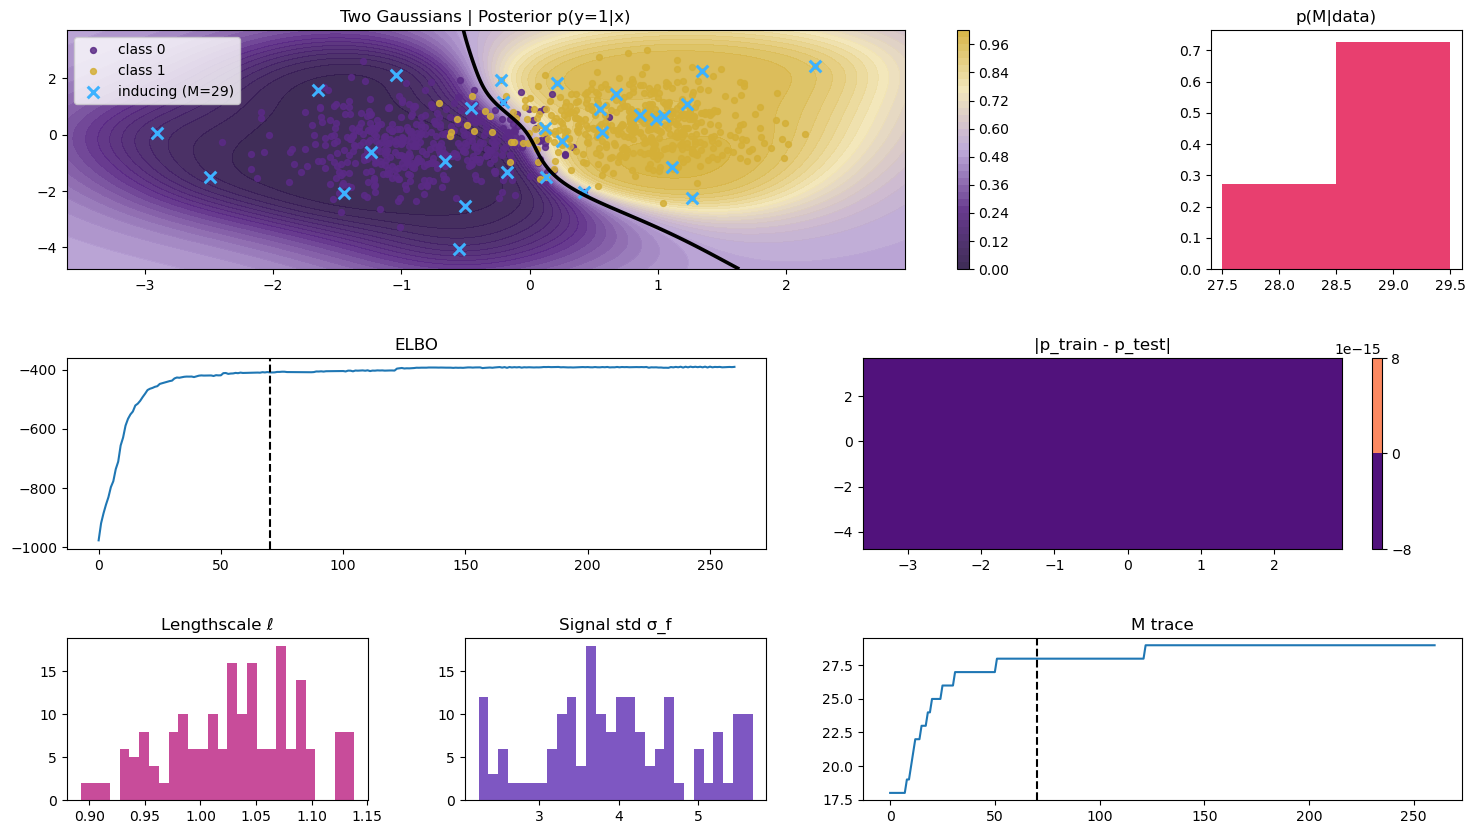


=== Two Gaussians (Noisy) ===
wall=3.68s | meanM=33.69
[test] acc=0.7822 | nll=0.5366


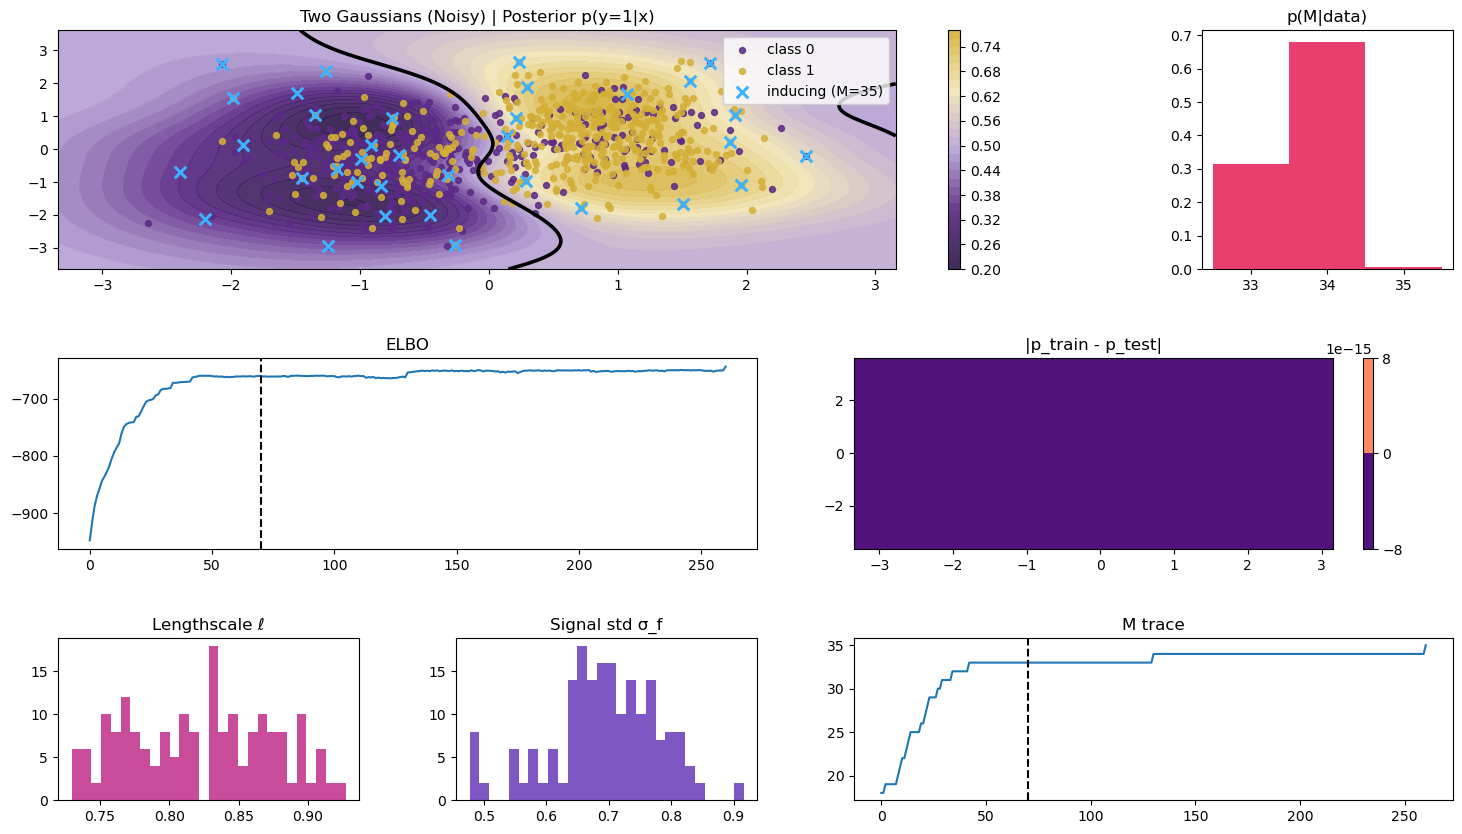


=== Moons-like ===
wall=3.36s | meanM=28.25
[test] acc=0.9644 | nll=0.1112


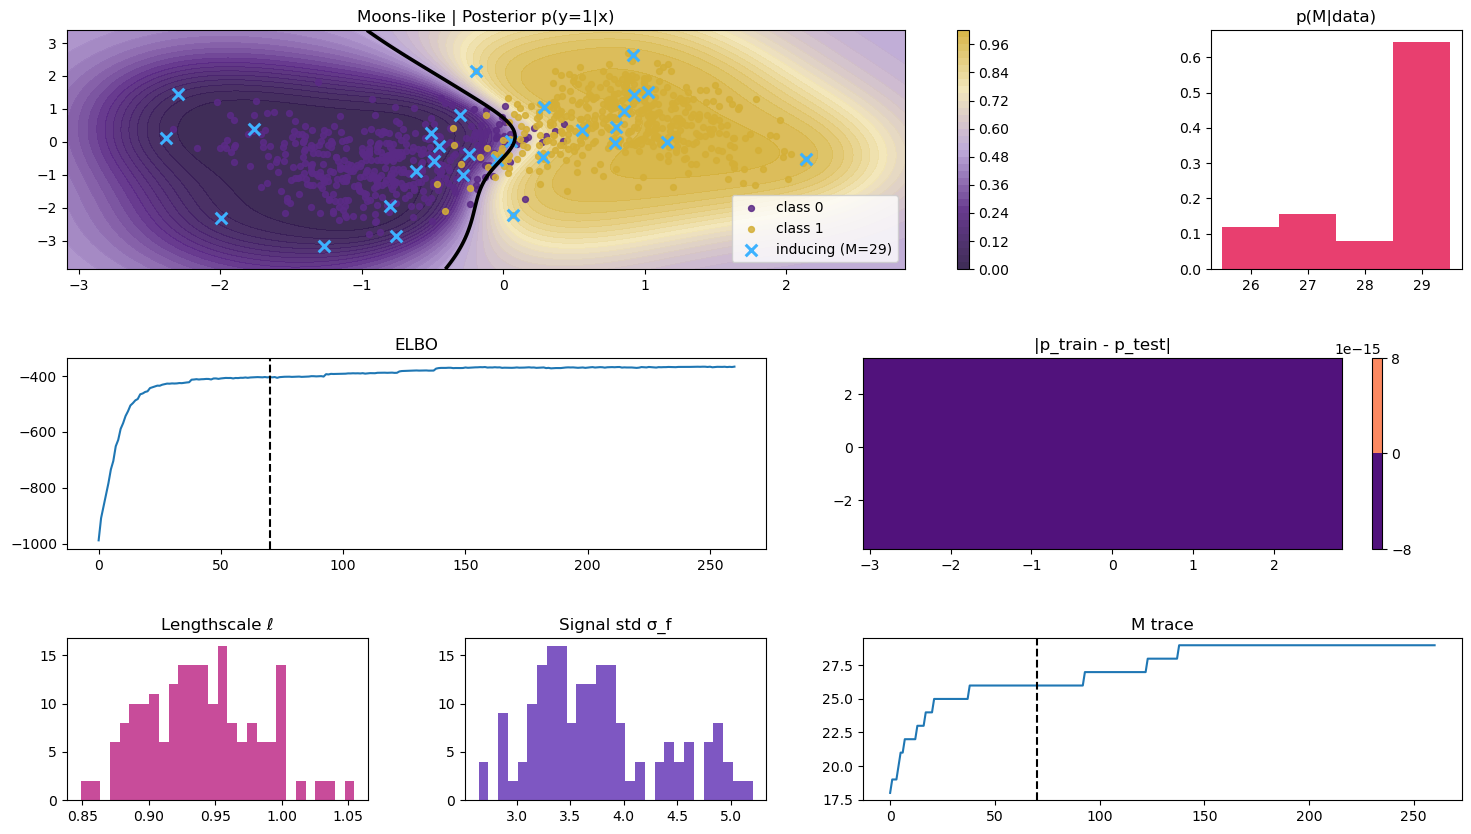


=== XOR ===
wall=3.77s | meanM=31.73
[test] acc=0.9911 | nll=0.0486


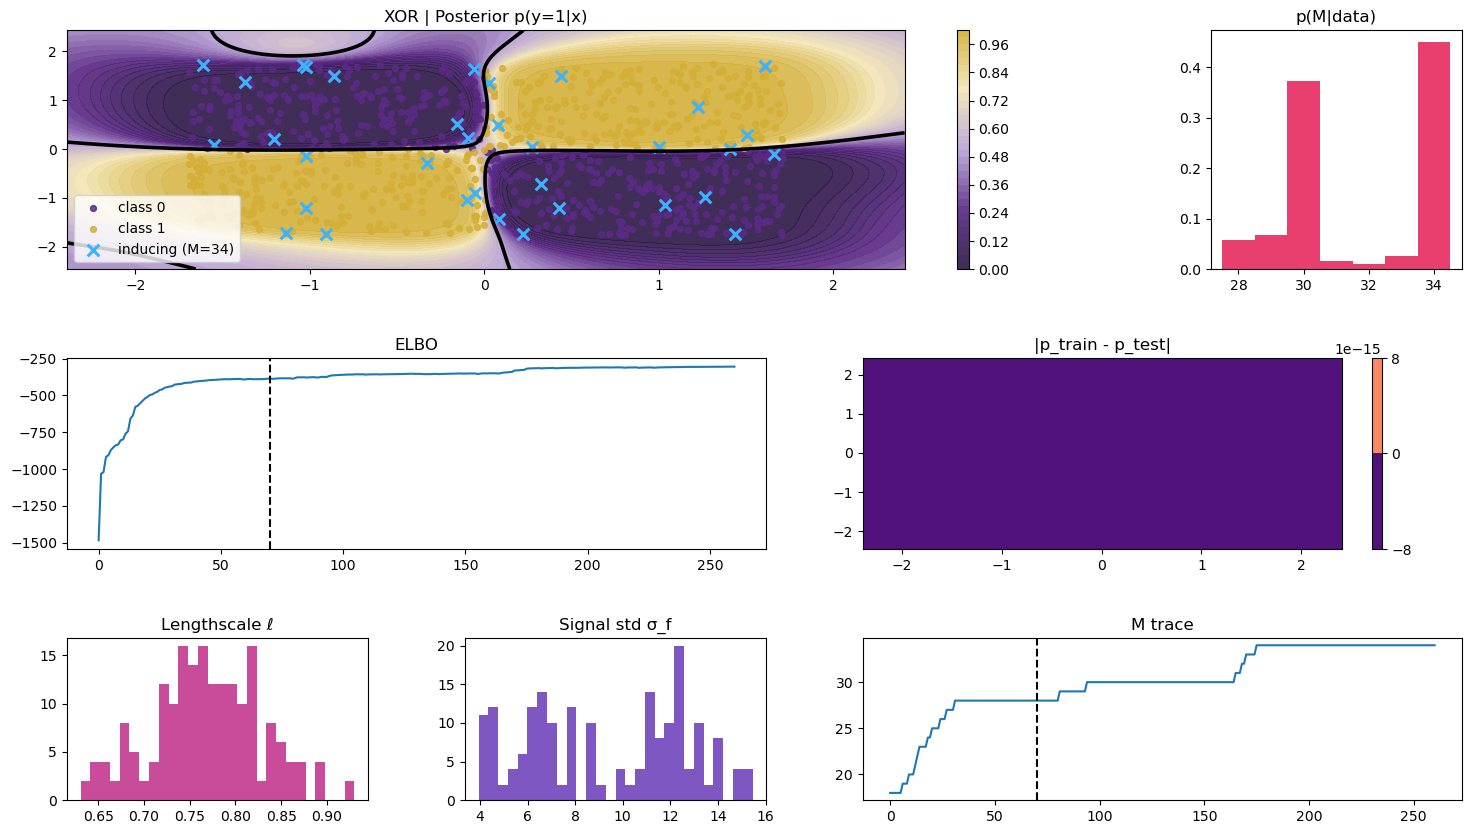


=== SUMMARY ===
Two Gaussians        | acc=0.9556 | nll=0.1206 | wall=5.73s
Two Gaussians (Noisy) | acc=0.7822 | nll=0.5366 | wall=3.68s
Moons-like           | acc=0.9644 | nll=0.1112 | wall=3.36s
XOR                  | acc=0.9911 | nll=0.0486 | wall=3.77s


In [41]:
def main_suite():
    cfg = Config()
    problems = [("Two Gaussians", *make_two_gaussians(seed=cfg.seed)), ("Two Gaussians (Noisy)", *make_two_gaussians_noisy(noise=0.25, seed=cfg.seed+1)), ("Moons-like", *make_moons_like(seed=cfg.seed+3)), ("XOR", *make_xor(seed=cfg.seed+4))]
    results = [run_one_binary_problem(name, X, y, cfg, i) for i, (name, X, y) in enumerate(problems)]
    print("\n=== SUMMARY ===")
    for r in results: print(f"{r['name']:<20} | acc={r['acc']:.4f} | nll={r['nll']:.4f} | wall={r['wall']:.2f}s")

if __name__ == "__main__":
    main_suite()